In [123]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import mediapipe as mp
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tqdm import tqdm

In [109]:
# MediaPipe setup for real-time prediction
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [42]:
# Dataset parameters
DATASET_PATH = './dataset/asl_alphabet_train/asl_alphabet_train/'
IMG_SIZE = 224  # MobileNetV2 default input size
BATCH_SIZE = 32
NUM_CLASSES = 29  # 26 letters + space + delete + nothing

In [44]:
# Prepare data generators
def prepare_data_generators():
    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Only rescaling for validation
    valid_datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        DATASET_PATH,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = valid_datagen.flow_from_directory(
        DATASET_PATH,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation'
    )

    num_classes = len(train_generator.class_indices)
    print(f"Number of classes: {num_classes}")
    print("Classes:", train_generator.class_indices)

    return train_generator, validation_generator, num_classes

In [46]:
# Use the pre-trained model
def create_model(num_classes):
    # Load the pre-trained model
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    
    # Freeze the pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model, base_model

In [66]:
# Train the model
def train_model(model, train_generator, validation_generator, base_model):
    # First phase: train only the top layers
    history1 = model.fit(
        train_generator,
        epochs=15,
        validation_data=validation_generator,
        callbacks=[
            EarlyStopping(patience=5, restore_best_weights=True),
            ModelCheckpoint('asl_model_phase1.h5.keras', save_best_only=True),
            ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-6)
        ]
    )

    # Second phase: fine-tune some conv layers along with top layers
    for layer in base_model.layers[-30:]:
        layer.trainable = True

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history2 = model.fit(
        train_generator,
        epochs=30,
        validation_data=validation_generator,
        callbacks=[
            EarlyStopping(patience=5, restore_best_weights=True),
            ModelCheckpoint('asl_model_phase2.h5', save_best_only=True),
            ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-6)
        ]
    )

    return model, [history1, history2]

In [48]:
def plot_training_history(histories):
    plt.figure(figsize=(12, 4))
    
    for i, history in enumerate(histories, 1):
        plt.subplot(1, 2, i)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Phase {i} Training')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

In [50]:
# Helper functions remain the same
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [52]:
def draw_styled_landmarks(image, results):
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(
            image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
        )
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(
            image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
        )

In [17]:
# # Function to preprocess frame for prediction
# def prepare_frame_for_prediction(frame):
#     resized = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
#     normalized = resized / 255.0
#     return np.expand_dims(normalized, axis=0)

In [68]:
print("Preparing data generators...")
train_generator, validation_generator, num_classes = prepare_data_generators()

if os.path.exists('asl_model_phase2.h5.keras'):
    print("Loading existing model...")
    model = load_model('asl_model_phase2.h5.keras')
else:
    print("Creating and training model...")
    model, base_model = create_model(num_classes)
    model, histories = train_model(model, train_generator, validation_generator, base_model)
    plot_training_history(histories)

Preparing data generators...
Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.
Number of classes: 29
Classes: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}
Creating and training model...
Epoch 1/15
 756/2175 ━━━━━━━━━━━━━━━━━━━━ 40:03 2s/step - accuracy: 0.3804 - loss: 2.1646


KeyboardInterrupt



In [58]:
# Real-time prediction
class_indices = {v: k for k, v in train_generator.class_indices.items()}

In [60]:
def test_real():
    # Real-time prediction
    cap = cv2.VideoCapture(0)
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            # Make detections
            image, results = mediapipe_detection(frame, holistic)
            draw_styled_landmarks(image, results)
            
            # Prepare frame and make prediction
            processed_frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
            processed_frame = tf.keras.applications.mobilenet_v2.preprocess_input(processed_frame)
            processed_frame = np.expand_dims(processed_frame, axis=0)
            
            prediction = model.predict(processed_frame)
            predicted_class = class_indices[np.argmax(prediction)]
            confidence = np.max(prediction)
            
            # Display prediction
            cv2.putText(image, f'Predicted: {predicted_class}', 
                        (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.putText(image, f'Confidence: {confidence:.2f}', 
                        (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
            cv2.imshow('ASL Recognition', image)
            
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
    
    cap.release()
    cv2.destroyAllWindows()

In [38]:
test_real()

C:\Users\abhis\anaconda3\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━

In [125]:
class ASLDataProcessor:
    def __init__(self, data_path, sequence_length=30):
        self.data_path = data_path
        self.sequence_length = sequence_length
        self.holistic = mp_holistic.Holistic(
            static_image_mode=True,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5
        )
        self.classes = sorted([d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))])
        self.num_classes = len(self.classes)

    def extract_landmarks(self, image):
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = self.holistic.process(image_rgb)
        
        landmarks = []
        
        # Extract hand landmarks (we'll focus on hands for ASL alphabet)
        if results.left_hand_landmarks:
            for landmark in results.left_hand_landmarks.landmark:
                landmarks.extend([landmark.x, landmark.y, landmark.z])
        if results.right_hand_landmarks:
            for landmark in results.right_hand_landmarks.landmark:
                landmarks.extend([landmark.x, landmark.y, landmark.z])
                
        # Pad landmarks to ensure fixed size (21 points per hand * 2 hands * 3 coordinates)
        padded_landmarks = landmarks + [0.0] * (126 - len(landmarks))
        return np.array(padded_landmarks[:126])

    def process_data(self):
        X = []
        y = []
        
        print("Processing data...")
        for class_idx, class_name in enumerate(tqdm(self.classes)):
            class_path = os.path.join(self.data_path, class_name)
            for image_name in os.listdir(class_path):
                if image_name.endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(class_path, image_name)
                    image = cv2.imread(image_path)
                    if image is not None:
                        landmarks = self.extract_landmarks(image)
                        X.append(landmarks)
                        y.append(class_idx)
        
        return np.array(X), np.array(y)

In [127]:
class ASLModel:
    def __init__(self, num_classes, sequence_length=30, landmark_dims=126):
        self.num_classes = num_classes
        self.sequence_length = sequence_length
        self.landmark_dims = landmark_dims
        self.model = self.create_model()

    def create_model(self):
        model = Sequential([
            LSTM(64, return_sequences=True, activation='relu', 
                 input_shape=(self.sequence_length, self.landmark_dims)),
            LSTM(128, return_sequences=True, activation='relu'),
            LSTM(64, return_sequences=False, activation='relu'),
            Dense(64, activation='relu'),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dense(self.num_classes, activation='softmax')
        ])
        
        model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def prepare_sequences(self, X, y):
        sequences = []
        sequence_labels = []
        
        for i in range(len(X) - self.sequence_length + 1):
            sequences.append(X[i:i + self.sequence_length])
            sequence_labels.append(y[i + self.sequence_length - 1])
        
        return np.array(sequences), np.array(sequence_labels)

In [129]:
def train_asl_model(data_path, epochs=50):
    # Initialize data processor and process data
    data_processor = ASLDataProcessor(data_path)
    X, y = data_processor.process_data()
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize model
    asl_model = ASLModel(num_classes=data_processor.num_classes)
    
    # Prepare sequences
    X_train_seq, y_train_seq = asl_model.prepare_sequences(X_train, y_train)
    X_test_seq, y_test_seq = asl_model.prepare_sequences(X_test, y_test)
    
    # Convert labels to categorical
    y_train_cat = to_categorical(y_train_seq, num_classes=data_processor.num_classes)
    y_test_cat = to_categorical(y_test_seq, num_classes=data_processor.num_classes)
    
    # Train model
    history = asl_model.model.fit(
        X_train_seq, y_train_cat,
        validation_data=(X_test_seq, y_test_cat),
        epochs=epochs,
        batch_size=32,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=5, min_lr=1e-6)
        ]
    )
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(122)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Save model
    asl_model.model.save('asl_model.h5')
    
    return asl_model, data_processor.classes

In [119]:
# Cell 4: Main Loop Function
def run_recognition():
    recognizer = ASLRecognizer()
    cap = cv2.VideoCapture(0)
    
    try:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            predicted_letter = recognizer.predict(frame)
            cv2.putText(frame, f'Predicted: {predicted_letter}', 
                        (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
            # Display frame and debug info
            display_frame(frame)
            print("\nDebug Information:")
            for key, value in recognizer.debug_info().items():
                print(f"{key}: {value}")
            
            # Plot landmarks
            if recognizer.last_landmarks is not None:
                plot_landmarks(recognizer.last_landmarks)
            
            time.sleep(0.1)  # Slow down the loop for Jupyter
            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        cap.release()
        cv2.destroyAllWindows()
    finally:
        cap.release()
        cv2.destroyAllWindows()

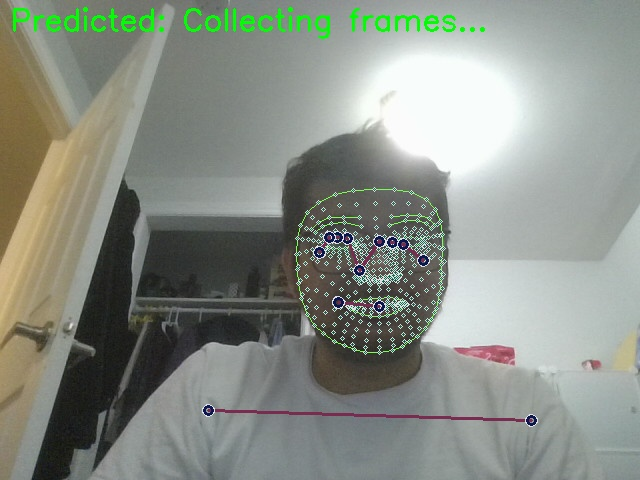


Debug Information:
Sequence Buffer Length: 25
Last Landmarks Shape: (543,)
Last Prediction Shape: None


KeyboardInterrupt: 

In [121]:
run_recognition()

In [ ]:
DATA_PATH = "./dataset/asl_alphabet_train/asl_alphabet_train/"  # Update this path
trained_model, class_names = train_asl_model(DATA_PATH)
print(f"Model trained on classes: {class_names}")

Processing data...


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]C:\Users\abhis\anaconda3\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
  3%|██▊                                                                             | 1/29 [05:49<2:43:04, 349.45s/it]